## RandomForestRegressor sales_margin

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Charger les données
chemin = "C:/Users/zineb/OneDrive/Bureau/hetic/DA/silver/data_clean.csv"
df = pd.read_csv(chemin)





In [3]:

# 2. Préparation des données

# Gérer les valeurs manquantes
# Remplacer les virgules par des points si nécessaire
df['revenue'] = df['revenue'].str.replace(',', '.', regex=True)

# Convertir la colonne revenue en type float
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').astype(float)


# verification des colonnes engage_at et close_at sont au format datetime
df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')

# Remplir les valeurs de close_value avec 0 pour les états engaging, prospecting, et lost
df.loc[df['deal_stage'].isin(['engaging', 'prospecting', 'lost']), 'close_value'] = 0



# Calculer la marge commerciale (sales_margin)
df['sales_margin'] = df.apply(
    lambda row: 0 if row['close_value'] == 0 else row['close_value'] - row['sales_price'],
    axis=1
)


# Calcul de la durée du cycle de vente (sales_cycle_days)
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days



# Vérifier les valeurs manquantes dans sales_margin
print("Nombre de NaN dans sales_margin avant traitement :", df['sales_margin'].isnull().sum())

# Remplacer les NaN dans sales_margin par 0
df['sales_margin'] = df['sales_margin'].fillna(0)


# Vérifier à nouveau pour s'assurer qu'il n'y a plus de NaN
print("Nombre de NaN dans sales_margin après traitement :", df['sales_margin'].isnull().sum())


# Afficher les premières lignes pour vérifier
print(df[['close_value', 'sales_price', 'sales_margin', 'sales_cycle_days']].head())
df = df.dropna(subset=['sales_margin'])



# Créer des colonnes temporelles dérivées
df['engage_year'] = df['engage_at'].dt.year
df['engage_month'] = df['engage_at'].dt.month
df['engage_day'] = df['engage_at'].dt.day
df['engage_weekday'] = df['engage_at'].dt.weekday  # Lundi=0, Dimanche=6

df['close_year'] = df['close_at'].dt.year
df['close_month'] = df['close_at'].dt.month
df['close_day'] = df['close_at'].dt.day
df['close_weekday'] = df['close_at'].dt.weekday

# Calculer la durée entre "engage_at" et "close_at" si applicable
df['sales_cycle_days'] = (df['close_at'] - df['engage_at']).dt.days

# Remplir les valeurs manquantes

df['sales_cycle_days'] = df['sales_cycle_days'].fillna(0)








Nombre de NaN dans sales_margin avant traitement : 664
Nombre de NaN dans sales_margin après traitement : 0
   close_value  sales_price  sales_margin  sales_cycle_days
0          0.0          550           0.0               7.0
1          0.0          550           0.0              13.0
2          0.0          550           0.0              69.0
3          0.0          550           0.0               2.0
4          0.0          550           0.0               2.0


C:\Users\zineb\AppData\Local\Temp\ipykernel_25592\1042122802.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['engage_at'] = pd.to_datetime(df['engage_at'], errors='coerce')
C:\Users\zineb\AppData\Local\Temp\ipykernel_25592\1042122802.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['close_at'] = pd.to_datetime(df['close_at'], errors='coerce')


In [4]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees', 'sales_margin',
       'sales_cycle_days', 'engage_year', 'engage_month', 'engage_day',
       'engage_weekday', 'close_year', 'close_month', 'close_day',
       'close_weekday'],
      dtype='object')

In [5]:

# Vérifier les types de données
print("Types des données avant encodage :\n", df.dtypes)

# Encoder les colonnes catégoriques avec LabelEncoder
label_encoders = {}
cat_columns = ['sales_agent', 'product', 'account', 'sector', 'series', 'manager', 'office_location', 'regional_office', 'deal_stage']

for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Types des données après encodage :\n", df.dtypes)



Types des données avant encodage :
 opportunity_id                 object
sales_agent                    object
product                        object
account                        object
deal_stage                     object
engage_at              datetime64[ns]
close_at               datetime64[ns]
close_value                   float64
sector                         object
series                         object
sales_price                     int64
manager                        object
office_location                object
regional_office                object
year_founded_at                 int64
revenue                       float64
number_of_employees             int64
sales_margin                  float64
sales_cycle_days              float64
engage_year                   float64
engage_month                  float64
engage_day                    float64
engage_weekday                float64
close_year                    float64
close_month                   float64
close_day     

In [6]:
# Remplir les valeurs manquantes dans les colonnes numériques
df['close_value'] = df['close_value'].fillna(0)
df['sales_margin'] = df['sales_margin'].fillna(0)


In [7]:
df.columns

Index(['opportunity_id', 'sales_agent', 'product', 'account', 'deal_stage',
       'engage_at', 'close_at', 'close_value', 'sector', 'series',
       'sales_price', 'manager', 'office_location', 'regional_office',
       'year_founded_at', 'revenue', 'number_of_employees', 'sales_margin',
       'sales_cycle_days', 'engage_year', 'engage_month', 'engage_day',
       'engage_weekday', 'close_year', 'close_month', 'close_day',
       'close_weekday'],
      dtype='object')

In [8]:
# Définir les caractéristiques (X) et la cible (y)


X = df.drop(columns=[ 'deal_stage', 'close_value', 'year_founded_at','sales_margin',
       'engage_at','close_at', 'sales_margin', 'sales_cycle_days',
       'opportunity_id','year_founded_at' , 'manager','close_year',  'engage_year', 'series'
       ])
y = df['sales_margin']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [9]:
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7370    0.0
7371    0.0
7372    0.0
7373    0.0
7374    0.0
Name: sales_margin, Length: 7375, dtype: float64

In [10]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [11]:
# Modèle de régression
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [12]:
# Prédiction et évaluation
y_pred = model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))



Mean Absolute Error: 120.00344406779661
R² Score: -0.11680459591154801


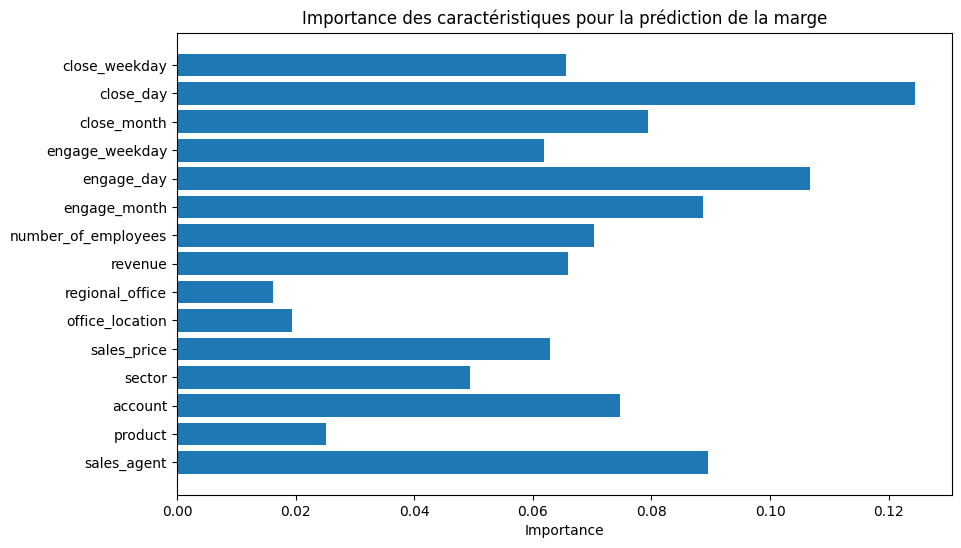

In [13]:

# Importance des caractéristiques
importances = model.feature_importances_
features = X.columns

# Graphique des importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Importance des caractéristiques pour la prédiction de la marge")
plt.show()


In [14]:
# Validation croisée
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print("\nScores de validation croisée :", cv_scores)
print("Précision moyenne (validation croisée) :", np.mean(cv_scores))




Scores de validation croisée : [ 0.         -0.15248307 -0.0095716  -0.01874962 -0.09083319]
Précision moyenne (validation croisée) : -0.05432749417418772


In [15]:
# Prédictions pour de nouvelles données
new_data = X_test[:5]  # un échantillon des données de test
predictions = model.predict(new_data)

# Arrondir les prédictions pour une lecture plus lisible
predictions_rounded = np.round(predictions, 2) 
# Désactiver la notation scientifique dans Numpy
np.set_printoptions(suppress=True, precision=2)

# Affichage des prédictions
print("Prédictions sur nouvelles données (simulées):", predictions_rounded)

Prédictions sur nouvelles données (simulées): [  20.52   -0.93  109.75    4.78 -246.28]


In [16]:
# Vérification de la fiabilité avec des métriques supplémentaires
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 64548.152208949155
Root Mean Squared Error: 254.06328386634138


In [17]:
# Analyse des produits et des secteurs les plus rentables
# Ajouter les prédictions au dataframe pour l'analyse
df_test = pd.DataFrame(X_test, columns=[col for col in df.columns if col in X.columns])
df_test['predicted_margin'] = y_pred

In [18]:
# Calculer la rentabilité moyenne par secteur et par produit
rentability_by_sector = df_test.groupby([col for col in df.columns if 'sector' in col])['predicted_margin'].mean()
rentability_by_product = df_test.groupby([col for col in df.columns if 'product' in col])['predicted_margin'].mean()

print("\nRentabilité moyenne par secteur (prédictions):")
print(rentability_by_sector)
print("\nRentabilité moyenne par produit (prédictions):")
print(rentability_by_product)


Rentabilité moyenne par secteur (prédictions):
sector
-1.965205     3.334426
-1.567974    -1.874176
-1.170742    -6.330775
-0.773511    -7.358592
-0.376279   -10.104671
 0.020952    -5.493180
 0.418184    -7.352090
 0.815415    -4.440960
 1.212647    -0.224978
 1.609878     1.203100
Name: predicted_margin, dtype: float64

Rentabilité moyenne par produit (prédictions):
product
-1.894374   -136.636000
-1.345026     -4.637058
-0.795679     -8.220809
-0.246331      8.380687
 0.303016     -3.095020
 0.852364    -10.669868
 1.401711     -2.504538
Name: predicted_margin, dtype: float64


In [19]:
X.columns

Index(['sales_agent', 'product', 'account', 'sector', 'sales_price',
       'office_location', 'regional_office', 'revenue', 'number_of_employees',
       'engage_month', 'engage_day', 'engage_weekday', 'close_month',
       'close_day', 'close_weekday'],
      dtype='object')

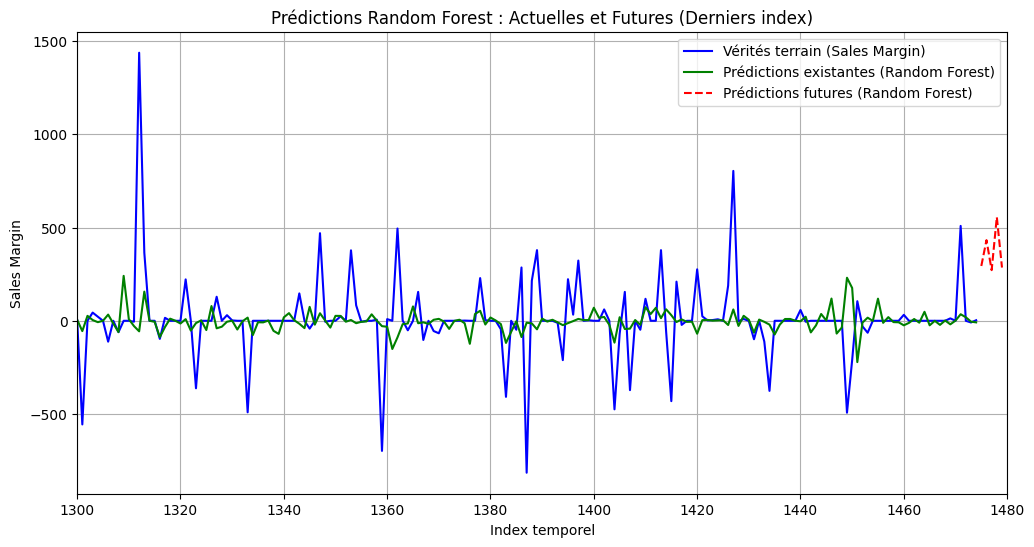

In [20]:
# Faire des prédictions
y_pred = model.predict(X_test)

# Générer de nouvelles données simulées (correspondant aux colonnes dans X)
future_data = pd.DataFrame({
    'sales_agent': [27, 29, 11, 15, 6],
    'account': [1, 2, 1, 2, 1],

    'manager': [3, 5, 1, 2, 4],
    'office_location': [1, 1, 1, 1, 1],
    'regional_office': [1, 2, 0, 2, 2],

    'revenue': [3178.24, 7708.38, 3178.24, 7708.38, 3178.24],
    'number_of_employees': [4540, 13756, 4540, 13756, 4540],
    'sales_cycle_days': [50, 60, 70, 80, 90],
    'sales_price': [1096.0, 1096.0, 55.0, 5482.0, 550.0],
    'sector_entertainment': [0, 0, 0, 0, 0],
    'sector_finance': [1, 1, 1, 1, 1],
    'sector_marketing': [0, 0, 0, 0, 0],
    'sector_medical': [0, 0, 0, 0, 0],
    'sector_retail': [0, 0, 0, 0, 0],
    'sector_services': [0, 0, 0, 0, 0],
    'sector_software': [0, 0, 0, 0, 0],
    'sector_technolgy': [0, 0, 0, 0, 0],
    'sector_telecommunications': [0, 0, 0, 0, 0],
    'product_GTX Basic': [1, 0, 0, 0, 0],
    'product_GTX Plus Basic': [0, 1, 0, 0, 0],
    'product_GTX Plus Pro': [0, 0, 1, 0, 0],
    'product_GTX Pro': [0, 0, 0, 1, 0],
    'product_MG Advanced': [0, 0, 0, 0, 1],
    'product_MG Special': [0, 0, 0, 0, 0],
    'deal_stage_Lost': [0, 0, 0, 0, 0],
    'deal_stage_Prospecting': [0, 0, 0, 0, 0],
    'deal_stage_Won': [1, 1, 1, 1, 1]
})

# Réindexation pour s'assurer que l'ordre des colonnes correspond à X.columns
future_data = future_data.reindex(columns=X.columns, fill_value=0)

# Conversion explicite des types pour correspondre aux données utilisées pour l'entraînement
for col in X.columns:
    future_data[col] = future_data[col].astype(X[col].dtype)

# Normaliser les nouvelles données
future_data_scaled = scaler.transform(future_data)

# Faire des prédictions pour les nouvelles données
future_predictions = model.predict(future_data_scaled)

# Tracer les résultats (à partir de l'index 1300)
start_index = 1300

plt.figure(figsize=(12, 6))

# Afficher les vraies valeurs des sales_margin pour le test
plt.plot(
    range(start_index, len(y_test)), 
    y_test[start_index:], 
    label="Vérités terrain (Sales Margin)", 
    color="blue"
)

# Afficher les prédictions existantes (Random Forest)
plt.plot(
    range(start_index, len(y_test)), 
    y_pred[start_index:], 
    label="Prédictions existantes (Random Forest)", 
    color="green"
)

# Afficher les prédictions pour les nouvelles données (future data)
plt.plot(
    range(len(y_test), len(y_test) + len(future_predictions)), 
    future_predictions, 
    label="Prédictions futures (Random Forest)", 
    color="red", 
    linestyle='--'
)

# Limiter l'affichage de l'axe X à partir de start_index
plt.xlim(start_index, len(y_test) + len(future_predictions))

# Ajouter des détails au graphique
plt.xlabel("Index temporel")
plt.ylabel("Sales Margin")
plt.title("Prédictions Random Forest : Actuelles et Futures (Derniers index)")
plt.legend()
plt.grid()

# Afficher le graphique
plt.show()
